In [1]:
import os
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

# Agenda

1. Data Preparation + Data Exploration  
2. Bag of Words
3. TF-IDF
4. Word Embeddings 
5. Sentence Embeddings
6. Create and Check Validation

# Resources
- https://scikit-learn.org/stable/modules/feature_extraction.html
- https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?datasetId=572515&sortBy=voteCount
- https://www.kaggle.com/code/paramarthasengupta/fake-news-detector-eda-prediction-99

# Data Preparation + Data Exploration

## Load 

In [2]:
os.listdir("../data/fake-and-real-news-dataset/")

['Fake.csv', 'True.csv']

In [3]:
fake = pd.read_csv("../data/fake-and-real-news-dataset/Fake.csv")
true = pd.read_csv("../data/fake-and-real-news-dataset/True.csv")

## Initial Exploration

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fake.iloc[0].to_dict()

{'title': ' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing',
 'text': 'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year

In [7]:
true.iloc[0].to_dict()

{'title': 'As U.S. budget fight looms, Republicans flip their fiscal script',
 'text': 'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proporti

## Merge tables

In [8]:
true['target'] = 1
fake['target'] = 0
df = pd.concat([true, fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


## Explore Columns

In [9]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

In [10]:
df["target"].value_counts()

0    23481
1    21417
Name: target, dtype: int64

In [11]:
df["subject"].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [12]:
# Transforming the unmatching subjects to the same notation
df["subject"] = df["subject"].replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})
df["subject"].value_counts()

PoliticsNews       18113
worldnews          10145
News                9050
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [13]:
df["date"]

0        December 31, 2017 
1        December 29, 2017 
2        December 31, 2017 
3        December 30, 2017 
4        December 29, 2017 
                ...        
44893      January 16, 2016
44894      January 16, 2016
44895      January 15, 2016
44896      January 14, 2016
44897      January 12, 2016
Name: date, Length: 44898, dtype: object

In [14]:
# TODO: Build fancy visualisations with timeline 

month_name_2_number = {calendar.month_name[number]:str(number) for number in range(1, 13)}
month_abbr_2_number = {calendar.month_abbr[number]:str(number) for number in range(1, 13)}

def convert_to_datetime_format(input):
    try:
        if "-" in input:
            d, m, y = input.split("-")
            y = "20" + y
        else:
            m, d, y = input.split()
        # Exclude `,`
        d = d[:-1]
        if m in month_name_2_number:
            m = month_name_2_number[m] 
        else:
            m = month_abbr_2_number[m]
        return f"{d}/{m}/{y}"
    except Exception as e:
        print(f"convert_to_datetime_format Failed on {input}. With Exception : {e}")
        return None
    
df["date"] = df["date"].apply(convert_to_datetime_format)
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

df["date"]

convert_to_datetime_format Failed on https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg. With Exception : not enough values to unpack (expected 3, got 2)
convert_to_datetime_format Failed on https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg. With Exception : not enough values to unpack (expe

0       2017-12-31
1       2017-12-29
2       2017-12-31
3       2017-12-30
4       2017-12-29
           ...    
44893   2016-01-16
44894   2016-01-16
44895   2016-01-15
44896   2016-01-14
44897   2016-01-12
Name: date, Length: 44898, dtype: datetime64[ns]

## Text Preparation

In [15]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            # len(token) > 2 and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [16]:
idx = 100

print(
    f"Before : {df['title'].iloc[idx]}\n"
    f"After : {preprocess(df['title'].iloc[idx])}"
)

Before : Senator Warren hits out at 'effort to politicize' U.S. consumer agency
After : senator warren hits effort politicize consumer agency


In [17]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_text'] = df['text'].apply(preprocess)
df['clean_original'] = df['original'].apply(preprocess)

## Text Visualisation

In [ ]:
plt.figure(figsize = (20,20)) 
plt.title("Fake Title News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 1, "clean_title"]))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Real Title News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 0, "clean_title"]))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Fake Text News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 1, "clean_text"]))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Real Text News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 0, "clean_text"]))
plt.imshow(wc, interpolation = 'bilinear')

## Examine Text statistics 

In [ ]:
df["clean_original_n_symbols"] = df["clean_original"].apply(len)
df["clean_original_n_words"] = df["clean_original"].apply(lambda x: len(nltk.tokenize.word_tokenize(x)))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("N symbols")
df.loc[df["target"] == 1, "clean_original_n_symbols"].hist(bins=30, label="True")
df.loc[df["target"] == 0, "clean_original_n_symbols"].hist(bins=30, label="False")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("N words")
df.loc[df["target"] == 1, "clean_original_n_words"].hist(bins=30, label="True")
df.loc[df["target"] == 0, "clean_original_n_words"].hist(bins=30, label="False")
plt.legend()
plt.show()

# Bag of Words

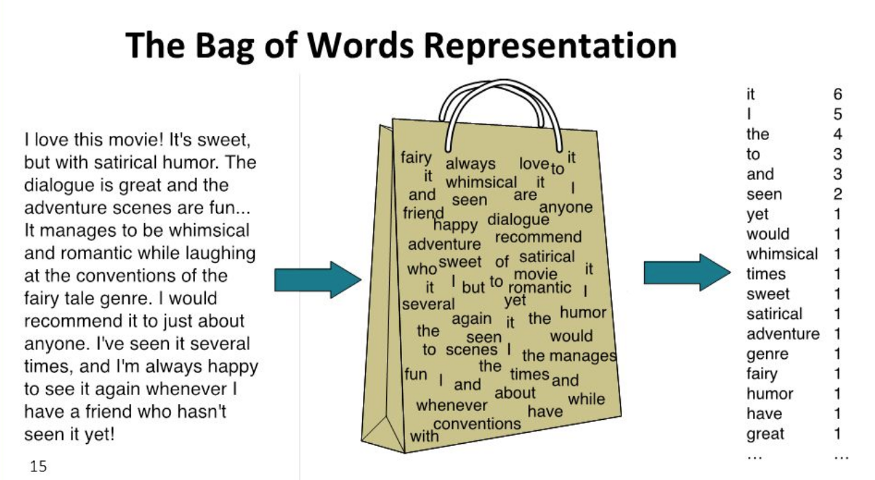

Advantages:
- Simple and Fast solution 
- Highly Explainable 
- ...

Disadvantages:
- Do not take into account token distribution across the corpus
- Arrangment information is lost 
- ...

In [ ]:
bag_of_words_object = CountVectorizer()
bag_of_words_matrix = bag_of_words_object.fit_transform(
    df["title"].iloc[:10]
)
print(f"Bag of Words: {bag_of_words_object.get_feature_names_out()}")
print(
    f"Text : {df['title'].iloc[0]}\n"
    f"Vectorization: {bag_of_words_object.transform([df['title'].iloc[0]]).toarray()[0]}"
)

In [ ]:
bag_of_words_object = CountVectorizer()
bag_of_words_matrix = bag_of_words_object.fit_transform(
    df["clean_title"].iloc[:10]
)
print(f"Bag of Words: {bag_of_words_object.get_feature_names_out()}")
print(
    f"Text : {df['clean_title'].iloc[0]}\n"
    f"Vectorization: {bag_of_words_object.transform([df['clean_title'].iloc[0]]).toarray()[0]}"
)

# Tf-Idf